In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
from scipy.stats import binom, ks_2samp
%matplotlib inline

sns.set(style="ticks")

In [2]:
nba_boxscore = pd.read_csv('./nba-enhanced-stats/2012-18_officialBoxScore.csv')
nba_boxscore.head()

,gmDate,gmTime,seasTyp,offLNm,offFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,WAS,East,Southeast,Away,Loss,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Smith,Michael,WAS,East,Southeast,Away,Loss,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
2,2012-10-30,19:00,Regular,Workman,Haywoode,WAS,East,Southeast,Away,Loss,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
3,2012-10-30,19:00,Regular,Brothers,Tony,CLE,East,Central,Home,Win,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
4,2012-10-30,19:00,Regular,Smith,Michael,CLE,East,Central,Home,Win,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409


In [3]:
nhl_boxscore = pd.read_csv('./nhl-game-data/game.csv')
nhl_teaminfo = pd.read_csv('./nhl-game-data/team_info.csv')
nhl_boxscore.head()

,game_id,season,type,date_time,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2011030221,20112012,P,2012-04-29,2012-04-29T19:00:00Z,1,4,3,4,home win OT,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
1,2011030222,20112012,P,2012-05-01,2012-05-01T23:30:00Z,1,4,4,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2011030223,20112012,P,2012-05-03,2012-05-03T23:30:00Z,4,1,3,4,home win OT,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
3,2011030224,20112012,P,2012-05-06,2012-05-06T23:30:00Z,4,1,2,4,home win REG,left,Prudential Center,/api/v1/venues/null,America/New_York,-4,EDT
4,2011030225,20112012,P,2012-05-08,2012-05-08T23:30:00Z,1,4,3,1,away win REG,right,Wells Fargo Center,/api/v1/venues/null,America/New_York,-4,EDT


In [4]:
def clean_nba(df):
    '''
    
        Cleans the nba_boxscore dataframe 
        - removes duplicates
        - add season column (indicates which season game was played in)
            - i.e. 2013-14, 2014-15, 2015-16, ...
        - remove unnecessary columns for analysis
        
        Args:
            df: original, uncleaned dataframe
        
        Returns:
            cleaned_df: cleaned dataframe
    '''
    # Remove unnecessary columns
    cleaned_df = df.loc[:, ['gmDate','gmTime','teamAbbr','opptAbbr','teamRslt','opptRslt']]
    
    # Add season column
    cleaned_df['season'] = ''
    cleaned_df['gmDate'] = pd.to_datetime(cleaned_df['gmDate'], format='%Y-%m-%d')
    cleaned_df.loc[(cleaned_df.gmDate >= '2013-10-29') & (cleaned_df.gmDate <= '2014-04-16'), 'season'] = '2013-14'
    cleaned_df.loc[(cleaned_df.gmDate >= '2014-10-28') & (cleaned_df.gmDate <= '2015-04-15'), 'season'] = '2014-15'
    cleaned_df.loc[(cleaned_df.gmDate >= '2015-10-27') & (cleaned_df.gmDate <= '2016-04-13'), 'season'] = '2015-16'
    cleaned_df.loc[(cleaned_df.gmDate >= '2016-10-25') & (cleaned_df.gmDate <= '2017-04-12'), 'season'] = '2016-17'
    cleaned_df.loc[(cleaned_df.gmDate >= '2017-10-17') & (cleaned_df.gmDate <= '2018-04-11'), 'season'] = '2017-18'
    
    # Remove duplicates
    cleaned_df = cleaned_df.drop_duplicates()
    return cleaned_df

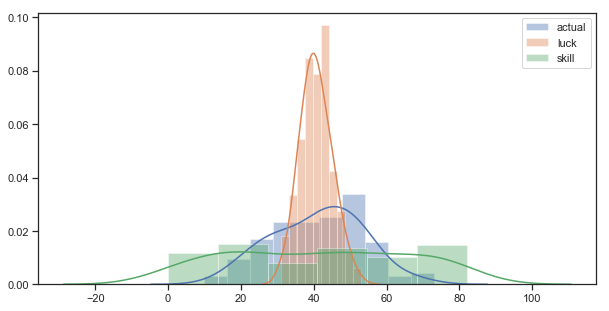

In [5]:
nba = clean_nba(nba_boxscore)

# Plot the actual wins
fig = plt.figure(figsize=(10,5))
seasons = ['2013-14','2014-15','2015-16','2016-17','2017-18']
nba = nba[nba.season.isin(seasons)]
nba['actual_wins'] = 1
nba.loc[nba['teamRslt'] == 'Loss', 'actual_wins'] = 0
nba_win_freq = nba.groupby(['teamAbbr','season']).sum().values.flatten()
sns.distplot(nba_win_freq)

# Plot a simulation of only luck
nba_all_luck = np.random.binomial(82, 0.5, size=len(nba_win_freq))
sns.distplot(nba_all_luck)

# Plot a simulation of only skill
nba_team_rank = {team_name: i for i, team_name in enumerate(nba_boxscore.teamAbbr.unique())}
nba['team_rank'] = nba.teamAbbr.map(nba_team_rank)
nba['oppt_rank'] = nba.opptAbbr.map(nba_team_rank)
nba['skill_win'] = 0
nba.loc[nba.team_rank < nba.oppt_rank, 'skill_win'] = 1
nba_all_skill = nba.groupby(['teamAbbr','season']).skill_win.sum().values.flatten()
sns.distplot(nba_all_skill)

# sns.distplot(nhl_win_freq)

plt.legend(['actual','luck','skill'])

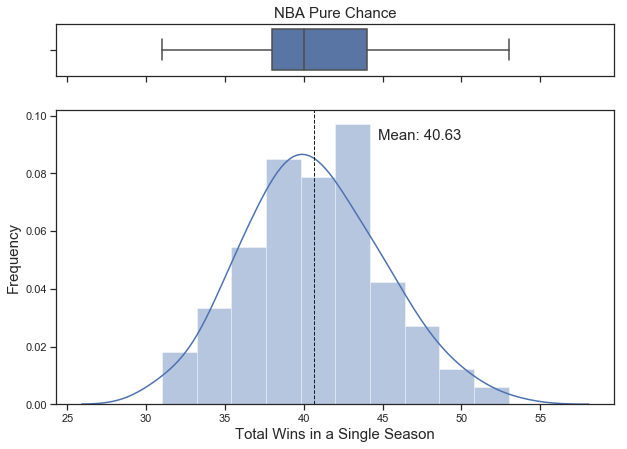

In [6]:
#Plot of pure luck in NBA

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,7))

sns.boxplot(nba_all_luck, ax=ax_box)
sns.distplot(nba_all_luck, ax=ax_hist)

min_ylim, max_ylim = ax_hist.get_ylim()
ax_hist.axvline(nba_all_luck.mean(), color='k', linestyle='dashed', linewidth=1)
ax_hist.text(nba_all_luck.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(nba_all_luck.mean()), fontsize=15)
plt.xlabel('Total Wins in a Single Season',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
ax_box.title.set_text("NBA Pure Chance")
ax_box.title.set_fontsize(15)
plt.show()

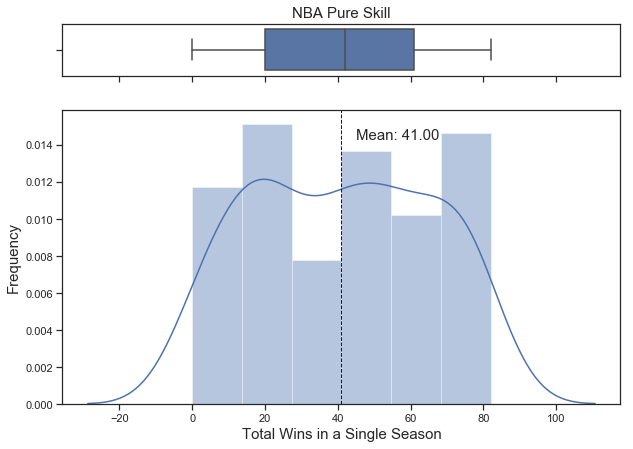

In [7]:
# Plot of pure skill in the NBA
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,7))

sns.boxplot(nba_all_skill, ax=ax_box)
sns.distplot(nba_all_skill, ax=ax_hist)

min_ylim, max_ylim = ax_hist.get_ylim()
ax_hist.axvline(nba_all_skill.mean(), color='k', linestyle='dashed', linewidth=1)
ax_hist.text(nba_all_skill.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(nba_all_skill.mean()), fontsize=15)
plt.xlabel('Total Wins in a Single Season',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
ax_box.title.set_text("NBA Pure Skill")
ax_box.title.set_fontsize(15)
plt.show()

In [8]:
def clean_nhl(df):
    '''
        Cleans the nba_boxscore dataframe 
        - removes duplicates
        - remove unnecessary columns for analysis
        
        Args:
            df: original, uncleaned dataframe
        
        Returns:
            cleaned_df: cleaned dataframe
    '''
    #We drop 2012-2013 season because the dataset for this season is incomplete
    cleaned_df = df[(df.type == 'R') & (df.season != 20122013)]
    
    # Remove unnecessary columns for analysis
    cleaned_df = cleaned_df.loc[:, ['game_id','season','home_team_id','away_team_id','outcome']]
    cleaned_df.rename(columns={'home_team_id': 'team_id', 'away_team_id': 'oppt_id'}, inplace=True)
    cleaned_df['actual_wins'] = 1
    cleaned_df.loc[cleaned_df.outcome.str.contains('away'), 'actual_wins'] = 0
    
    # We want dataset to have two entries per single game, perspective of both teams
    new_df = cleaned_df.copy()
    new_df.rename(columns={'team_id': 'oppt_id', 'oppt_id': 'team_id'}, inplace=True)
    new_df['actual_wins'] = 1
    new_df.loc[new_df.outcome.str.contains('home'), 'actual_wins'] = 0
    
    cleaned_df = cleaned_df.append(new_df, ignore_index=True, sort=True)
    return cleaned_df

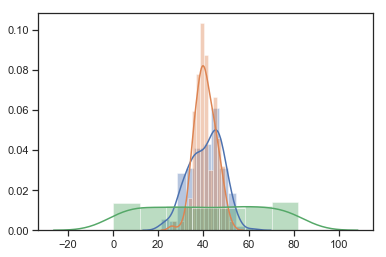

In [9]:
nhl = clean_nhl(nhl_boxscore)

# Plot the actual wins from dataset
nhl_win_freq = nhl.groupby(['team_id','season']).actual_wins.sum().values.flatten()
sns.distplot(nhl_win_freq)

# Plot the wins due to pure luck
nhl_all_luck = np.random.binomial(82, 0.5, size=len(nhl_win_freq))
sns.distplot(nhl_all_luck)

# Plot a simulation of only skill
nhl_team_rank = {team_id: i for i, team_id in enumerate(nhl.team_id.unique())}
nhl['team_rank'] = nhl.team_id.map(nhl_team_rank)
nhl['oppt_rank'] = nhl.oppt_id.map(nhl_team_rank)
nhl['skill_win'] = 0
nhl.loc[nhl.team_rank < nhl.oppt_rank, 'skill_win'] = 1
nhl_all_skill_win_freq = nhl.groupby(['team_id','season']).skill_win.sum().values.flatten()
sns.distplot(nhl_all_skill_win_freq)

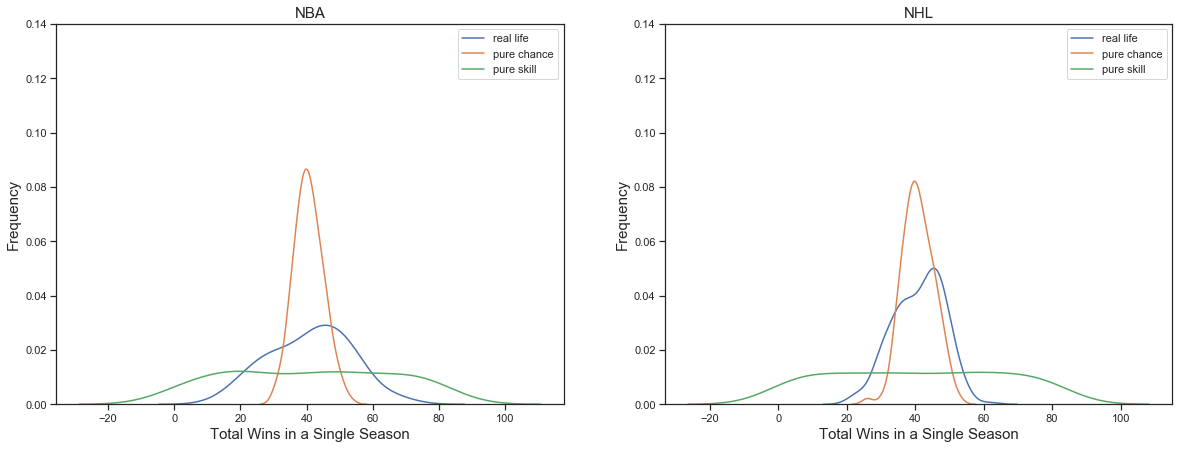

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.distplot(nba_win_freq, hist = False, label='real life')
sns.distplot(nba_all_luck, hist = False, label='pure chance')
sns.distplot(nba_all_skill, hist = False, label='pure skill')
plt.ylim(0, 0.14)
plt.title("NBA",fontsize=15)
plt.xlabel('Total Wins in a Single Season',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend()

plt.subplot(1,2,2)
sns.distplot(nhl_win_freq, hist = False, label='real life')
sns.distplot(nhl_all_luck, hist = False, label='pure chance')
sns.distplot(nhl_all_skill_win_freq, hist = False, label='pure skill')
plt.ylim(0, 0.14)
plt.title("NHL",fontsize=15)
plt.xlabel('Total Wins in a Single Season',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend()
plt.show()

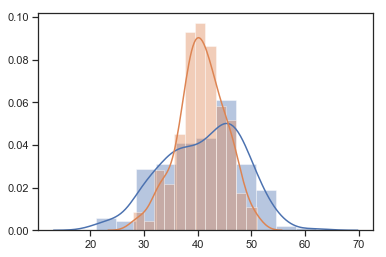

In [11]:
nhl['skill_and_luck'] = 0
for i in nhl.index:
    luck = 1
    if np.random.random() > luck:
        nhl.at[i, 'skill_and_luck'] = nhl.at[i,'skill_win']
    else:
        nhl.at[i, 'skill_and_luck'] = np.random.randint(0,2)
        
nhl_skill_and_luck= nhl.groupby(['team_id','season']).skill_and_luck.sum().values.flatten()

sns.distplot(nhl_win_freq)
sns.distplot(nhl_skill_and_luck)

Luck = 0 	 p_value = 0.0002709261819695189
Luck = 0.2 	 p_value = 0.006178630287773508
Luck = 0.4 	 p_value = 0.16722328225274036
Luck = 0.6 	 p_value = 0.705507086131043
Luck = 0.8 	 p_value = 0.006178630287773508
Luck = 1 	 p_value = 1.9219370281025083e-05


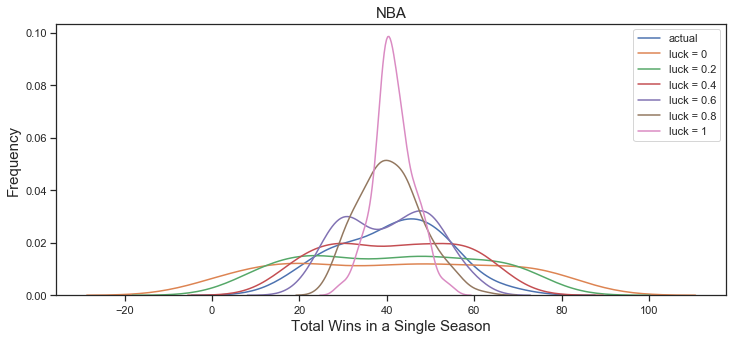

In [12]:
# Simulation to find the most optimal luck for NBA
plt.figure(figsize=(12,5))

luck_values = [0,0.2,0.4,0.6,0.8,1]
sns.distplot(nba_win_freq, hist=False, label = 'actual')
for luck in luck_values:
    nba['skill_and_luck'] = 0
    for i in nba.index:
        if np.random.random() > luck:
            nba.at[i,'skill_and_luck'] = nba.at[i, 'skill_win']
        else:
            nba.at[i, 'skill_and_luck'] = np.random.randint(0,2)
    nba_skill_and_luck = nba.groupby(['teamAbbr','season']).skill_and_luck.sum().values.flatten()
    pvalue = ks_2samp(nba_win_freq, nba_skill_and_luck).pvalue
    print("Luck = {} \t p_value = {}".format(luck, pvalue))
    sns.distplot(nba_skill_and_luck, hist=False, label = 'luck = {}'.format(luck))
    
plt.legend()
plt.title("NBA",fontsize=15)
plt.xlabel('Total Wins in a Single Season',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

0.8345382671632409


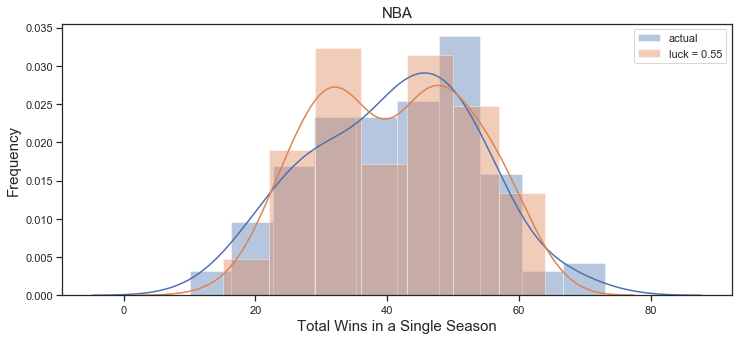

In [13]:
# Multiple simulations to determine p-value with optimal luck threshold
plt.figure(figsize=(12,5))

nba_pvalues = []
for _ in range(25):
    nba['skill_and_luck'] = 0
    for i in nba.index:
        luck = 0.55
        if np.random.random() > luck:
            nba.at[i, 'skill_and_luck'] = nba.at[i,'skill_win']
        else:
            nba.at[i, 'skill_and_luck'] = np.random.randint(0,2)  
    nba_skill_and_luck= nba.groupby(['teamAbbr','season']).skill_and_luck.sum().values.flatten()
    pvalue = ks_2samp(nba_win_freq, nba_skill_and_luck).pvalue
    nba_pvalues.append(pvalue)
    
nba_pvalues = np.array(nba_pvalues)
sns.distplot(nba_win_freq, label = 'actual')
sns.distplot(nba_skill_and_luck, label = 'luck = 0.55')
plt.legend()
plt.title("NBA",fontsize=15)
plt.xlabel('Total Wins in a Single Season',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
print(nba_pvalues.mean())

Luck = 0 	 p_value = 2.1738291782240597e-13
Luck = 0.2 	 p_value = 1.7382737150420877e-10
Luck = 0.4 	 p_value = 5.5370248471231346e-06
Luck = 0.6 	 p_value = 0.0022982208895155165
Luck = 0.8 	 p_value = 0.1747711535231834
Luck = 1 	 p_value = 0.0003806715008564502


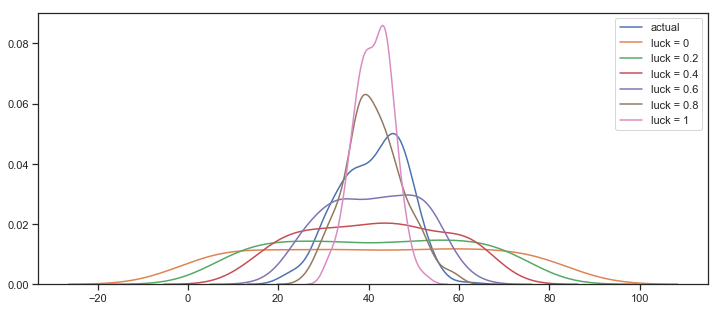

In [14]:
# Simulation to find the most optimal luck for NHL
plt.figure(figsize=(12,5))

luck_values = [0,0.2,0.4,0.6,0.8,1]
sns.distplot(nhl_win_freq, hist = False, label = 'actual')

for luck in luck_values:
    nhl['skill_and_luck'] = 0
    for i in nhl.index:
        if np.random.random() > luck:
            nhl.at[i, 'skill_and_luck'] = nhl.at[i, 'skill_win']
        else:
            nhl.at[i, 'skill_and_luck'] = np.random.randint(0,2)
        
    nhl_skill_and_luck = nhl.groupby(['team_id','season']).skill_and_luck.sum().values.flatten()
    
    pvalue = ks_2samp(nhl_win_freq, nhl_skill_and_luck).pvalue
    print('Luck = {} \t p_value = {}'.format(luck, pvalue))
    sns.distplot(nhl_skill_and_luck, hist = False, label = 'luck = {}'.format(luck))

plt.legend()
plt.show()

0.75669596042772


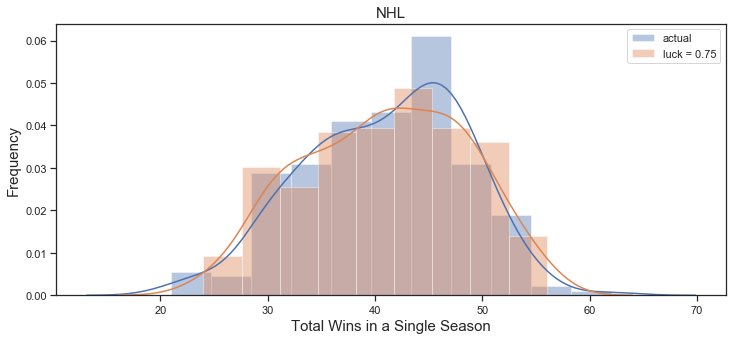

In [15]:
# Simulation to find the most optimal luck for NHL
plt.figure(figsize=(12,5))

sns.distplot(nhl_win_freq, label = 'actual')

nhl_pvalues = []

for _ in range(25):
    nhl['skill_and_luck'] = 0
    for i in nhl.index:
        luck = 0.75
        if np.random.random() > luck:
            nhl.at[i, 'skill_and_luck'] = nhl.at[i, 'skill_win']
        else:
            nhl.at[i, 'skill_and_luck'] = np.random.randint(0,2)
        
    nhl_skill_and_luck = nhl.groupby(['team_id','season']).skill_and_luck.sum().values.flatten()
    
    pvalue = ks_2samp(nhl_win_freq, nhl_skill_and_luck).pvalue
#     print(pvalue)
    nhl_pvalues.append(pvalue)

nhl_pvalues = np.array(nhl_pvalues)
print(nhl_pvalues.mean())
sns.distplot(nhl_skill_and_luck, label = 'luck = {}'.format(luck))

plt.legend()
plt.title("NHL",fontsize=15)
plt.xlabel('Total Wins in a Single Season',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

## Simulating playoffs for basketball (best of 7 vs best of 5 vs best of 3)
Assuming that the skill-luck breakdown of basketball is 55% luck and 45% skill.

In [16]:
def play_series(luck=0.55, best_of = 7):
    '''
    Simulates a single best-of-x series.
    
    Args:
        luck: percentage of luck in the luck-to-skill breakdown of a sport
        best_of: determines the playoff tournament format
    
    Returns:
        0 if underdogs lose
        1 if underdogs win
    '''
    favored_score = 0
    underdog_score = 0
    for _ in range(best_of):
        if np.random.random() > luck:
            favored_score += 1
        else:
            rng = np.random.randint(0,2)
            if rng == 1:
                underdog_score += 1
            else:
                favored_score += 1
                
    if favored_score > underdog_score:
        return 0
    
    else:
        return 1

Text(0.5, 0.98, 'Distribution of Total Number of Underdog Upsets in a Playoff Series for Different Number of "best_of" Values')

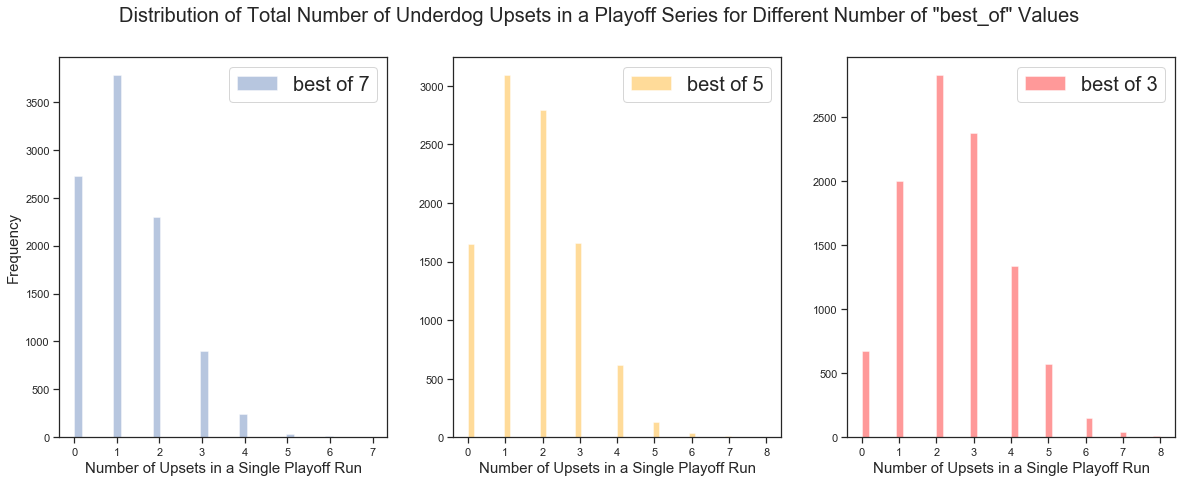

In [17]:
fig = plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
best_of_7 = []

#Simulating 10000 playoff seasons
for _ in range(10000):
    num_upsets = 0
    for _ in range(13):
        num_upsets += play_series()
    best_of_7.append(num_upsets)
sns.distplot(best_of_7, kde=False, label = 'best of 7')
plt.legend(prop={'size': 20})
plt.xlabel('Number of Upsets in a Single Playoff Run', fontsize=15)
plt.ylabel('Frequency', fontsize=15)


plt.subplot(1,3,2)
best_of_5 = []
#Simulating 10000 playoff seasons
for _ in range(10000):
    num_upsets = 0
    for _ in range(13):
        num_upsets += play_series(best_of = 5)
    best_of_5.append(num_upsets)

sns.distplot(best_of_5, kde=False, label = 'best of 5', color='orange')
plt.legend(prop={'size': 20})
plt.xlabel('Number of Upsets in a Single Playoff Run', fontsize=15)

plt.subplot(1,3,3)
best_of_3 = []
#13 matches played in a single playoff series
for _ in range(10000):
    num_upsets = 0
    for _ in range(13):
        num_upsets += play_series(best_of = 3)
    best_of_3.append(num_upsets)

sns.distplot(best_of_3, kde=False, label = 'best of 3', color='red')
plt.legend(prop={'size': 20})
plt.xlabel('Number of Upsets in a Single Playoff Run', fontsize=15)

fig.suptitle('Distribution of Total Number of Underdog Upsets in a Playoff Series for Different Number of "best_of" Values',
            fontsize=20)

Text(0.5, 0, 'Number of Upsets in a Single Playoff Run')

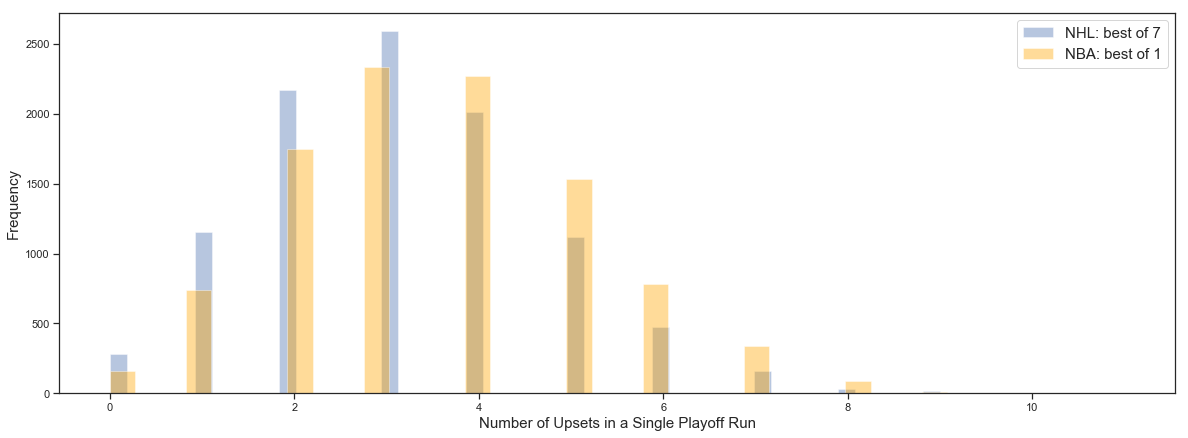

In [18]:
#Overlapping histograms:
# NHL: best of 7 and NBA: best of 1
fig = plt.figure(figsize=(20,7))

# HOCKEY SIMULATION W/ BEST OF 7
best_of_7 = []
for _ in range(10000):
    num_upsets = 0
    for _ in range(13):
        num_upsets += play_series(luck=0.75)
    best_of_7.append(num_upsets)
sns.distplot(best_of_7, kde=False, label = 'NHL: best of 7')
plt.legend()
plt.xlabel('Number of Upsets in a Single Playoff Run', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# BASKETBALL SIMULATION W/ BEST OF 1
best_of_1 = []
for _ in range(10000):
    num_upsets = 0
    for _ in range(13):
        num_upsets += play_series(best_of = 1)
    best_of_1.append(num_upsets)

sns.distplot(best_of_1, kde=False, label = 'NBA: best of 1', color='orange')
plt.legend(prop={'size': 15})
plt.xlabel('Number of Upsets in a Single Playoff Run', fontsize=15)